In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from pprint import pprint
from scipy import interp
from itertools import cycle

from nltk.corpus import stopwords

from nltk.stem.porter import *
from nltk.stem.lancaster import *
from nltk.stem.wordnet import *

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

In [3]:
random_state = 7

# Load Data

In [24]:
# https://raw.githubusercontent.com/ZhibingChen/DM-Reuters21578/master/reutersCSV.csv
df = pd.read_csv('~/dev/rtc/data/text/reuters21578/reutersCSV.csv', encoding='iso-8859-1')

## Columns

In [25]:
df.columns

Index(['pid', 'fileName', 'purpose', 'topic.acq', 'topic.alum',
       'topic.austdlr', 'topic.austral', 'topic.barley', 'topic.bfr',
       'topic.bop',
       ...
       'topic.tung', 'topic.tung.oil', 'topic.veg.oil', 'topic.wheat',
       'topic.wool', 'topic.wpi', 'topic.yen', 'topic.zinc', 'doc.title',
       'doc.text'],
      dtype='object', length=140)

### Topics

In [26]:
all_topics = [ re.sub('topic\.', '', col) for col in df.columns if col.startswith('topic.') ]
print(len(all_topics))
pprint(all_topics)

135
['acq',
 'alum',
 'austdlr',
 'austral',
 'barley',
 'bfr',
 'bop',
 'can',
 'carcass',
 'castor.meal',
 'castor.oil',
 'castorseed',
 'citruspulp',
 'cocoa',
 'coconut',
 'coconut.oil',
 'coffee',
 'copper',
 'copra.cake',
 'corn',
 'corn.oil',
 'cornglutenfeed',
 'cotton',
 'cotton.meal',
 'cotton.oil',
 'cottonseed',
 'cpi',
 'cpu',
 'crude',
 'cruzado',
 'dfl',
 'dkr',
 'dlr',
 'dmk',
 'drachma',
 'earn',
 'escudo',
 'f.cattle',
 'ffr',
 'fishmeal',
 'flaxseed',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut.meal',
 'groundnut.oil',
 'heat',
 'hk',
 'hog',
 'housing',
 'income',
 'instal.debt',
 'interest',
 'inventories',
 'ipi',
 'iron.steel',
 'jet',
 'jobs',
 'l.cattle',
 'lead',
 'lei',
 'lin.meal',
 'lin.oil',
 'linseed',
 'lit',
 'livestock',
 'lumber',
 'lupin',
 'meal.feed',
 'mexpeso',
 'money.fx',
 'money.supply',
 'naphtha',
 'nat.gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm.meal',
 'palm.oil',
 'palmk

### Non-topic columns

In [27]:
other_cols = [ col for col in df.columns if not col.startswith('topic.') ]
print(len(other_cols))
pprint(other_cols)

5
['pid', 'fileName', 'purpose', 'doc.title', 'doc.text']


### A closer look at topics -- choose single-topic docs

In [28]:
df[['doc.title', 'doc.text']]

,doc.title,doc.text
0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...
1,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...
2,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...
3,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...
4,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...
5,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...
6,RED LION INNS FILES PLANS OFFERING,Red Lion Inns Limited Partnership said it file...
7,USX &lt;X> DEBT DOWGRADED BY MOODY'S,Moody's Investors Service Inc said it lowered ...
8,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...
9,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,Computer Terminal Systems Inc said it has comp...


In [29]:
def topic_list_from_one_hot(one_hot):
    return [ topic for (has, topic) in zip(one_hot, all_topics) if has == 1 ]

In [30]:
one_hot_topics = df.values[:,3:-3]

In [31]:
docs_topics = [ topic_list_from_one_hot(one_hot) for one_hot in one_hot_topics ]

In [32]:
df['doc.topics'] = pd.Series(docs_topics)
print(len(df), len(df.dropna()), len(df))
df = df.dropna()

21578 19043 21578


In [33]:
df_more_than_one_topic = df[['purpose', 'doc.title', 'doc.text', 'doc.topics']][df.apply(
    lambda it: len(it['doc.topics']) > 0, axis=1
)]
print(len(df_more_than_one_topic))
df_more_than_one_topic.head()

10335


,purpose,doc.title,doc.text,doc.topics
0,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,[cocoa]
4,train,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,"[barley, corn, grain, oat, sorghum, wheat]"
5,train,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,"[corn, grain, lin.oil, linseed, oilseed, sorgh..."
8,train,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,[earn]
9,train,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,Computer Terminal Systems Inc said it has comp...,[acq]


In [54]:
df_one_topic = df[['purpose', 'doc.title', 'doc.text', 'doc.topics']][df.apply(lambda it: len(it['doc.topics']) == 1, axis=1)]
print(len(df_one_topic))
df_one_topic.head()

8625


,purpose,doc.title,doc.text,doc.topics
0,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,[cocoa]
8,train,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,[earn]
9,train,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,Computer Terminal Systems Inc said it has comp...,[acq]
10,train,COBANCO INC &lt;CBCO> YEAR NET,"Shr 34 cts vs 1.19 dlrs Net 807,000 vs 2,8...",[earn]
12,train,AM INTERNATIONAL INC &lt;AM> 2ND QTR JAN 31,Oper shr loss two cts vs profit seven cts ...,[earn]


In [55]:
df_one_topic['doc.topic'] = df_one_topic.apply(lambda row: row['doc.topics'][0], axis = 1)
df_one_topic = df_one_topic.drop(['doc.topics'], axis = 1)
df_one_topic.head()

,purpose,doc.title,doc.text,doc.topic
0,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,cocoa
8,train,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,earn
9,train,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,Computer Terminal Systems Inc said it has comp...,acq
10,train,COBANCO INC &lt;CBCO> YEAR NET,"Shr 34 cts vs 1.19 dlrs Net 807,000 vs 2,8...",earn
12,train,AM INTERNATIONAL INC &lt;AM> 2ND QTR JAN 31,Oper shr loss two cts vs profit seven cts ...,earn


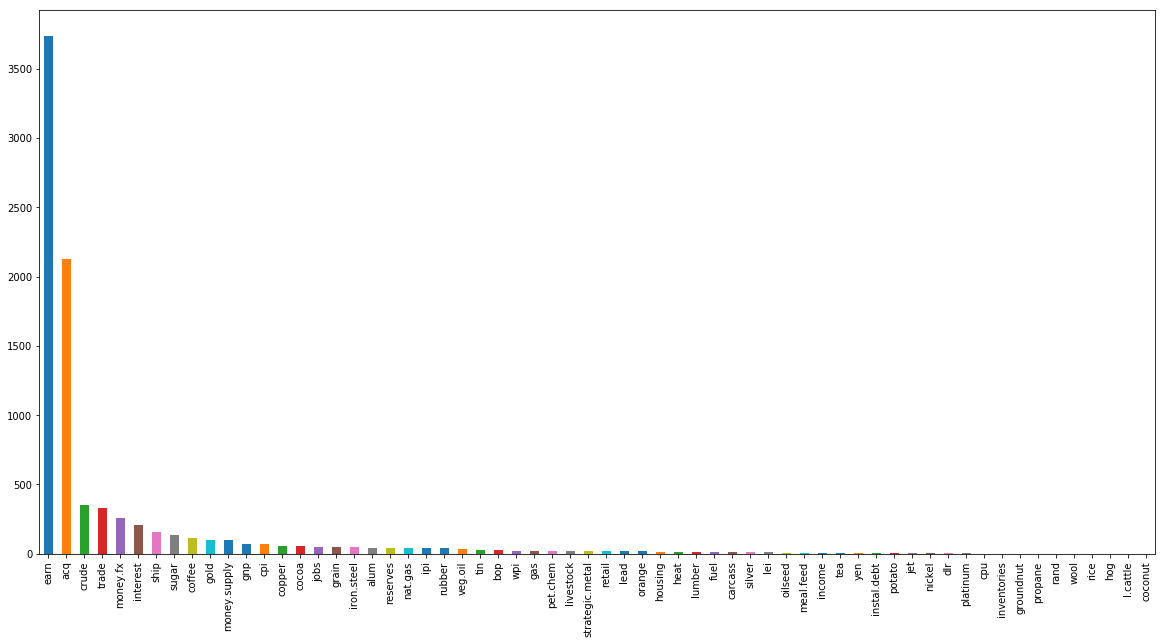

In [56]:
selected_topics_series = df_one_topic['doc.topic'].value_counts()
selected_topics_series.plot(kind='bar', figsize=(20, 10))

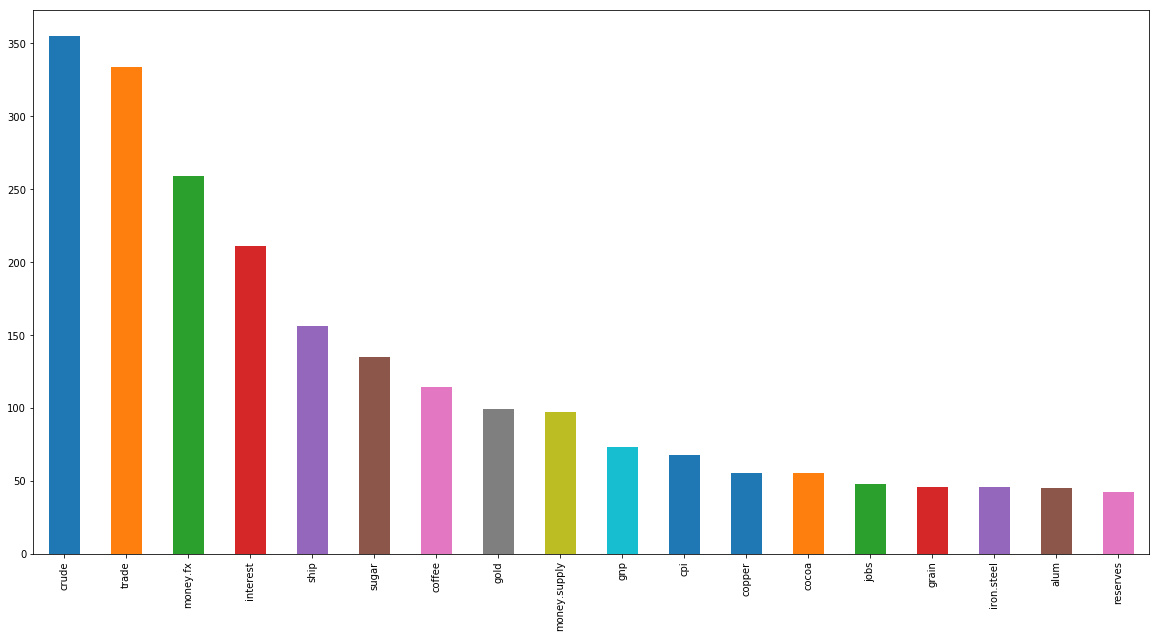

In [130]:
selected_topics_series = df_one_topic['doc.topic'].value_counts()[2:20]
selected_topics_series.plot(kind='bar', figsize=(20, 10))

In [131]:
selected_topics = selected_topics_series.index.values

# just for pretty print
selected_topics_df = pd.DataFrame({'count' : selected_topics_series})
selected_topics_df

,count
crude,355
trade,334
money.fx,259
interest,211
ship,156
sugar,135
coffee,114
gold,99
money.supply,97
gnp,73


In [132]:
data = df_one_topic[df_one_topic.apply(lambda it: it['doc.topic'] in selected_topics, axis=1)]
print(len(df_one_topic))
print(len(data))
data.head()

8625
2238


,purpose,doc.title,doc.text,doc.topic
0,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,cocoa
21,train,MAGMA LOWERS COPPER 0.75 CENT TO 66 CTS,"Magma Copper Co, a subsidiary of Newmont Minin...",copper
41,train,ICO PRODUCERS TO PRESENT NEW COFFEE PROPOSAL,"International Coffee Organization, ICO, produc...",coffee
45,train,U.S. SUGAR IMPORTS DOWN IN WEEK - USDA,Sugar imports subject to the U.S. sugar import...,sugar
46,train,BRAZIL ANTI-INFLATION PLAN LIMPS TO ANNIVERSARY,"inflation plan, initially hailed at home and a...",trade


In [133]:
data_train = data[data['purpose'] == 'train']
data_test = data[data['purpose'] == 'test']

In [134]:
len(data_train), len(data_test)

(1514, 523)

In [135]:
data_train.head()

,purpose,doc.title,doc.text,doc.topic
0,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,cocoa
21,train,MAGMA LOWERS COPPER 0.75 CENT TO 66 CTS,"Magma Copper Co, a subsidiary of Newmont Minin...",copper
41,train,ICO PRODUCERS TO PRESENT NEW COFFEE PROPOSAL,"International Coffee Organization, ICO, produc...",coffee
45,train,U.S. SUGAR IMPORTS DOWN IN WEEK - USDA,Sugar imports subject to the U.S. sugar import...,sugar
46,train,BRAZIL ANTI-INFLATION PLAN LIMPS TO ANNIVERSARY,"inflation plan, initially hailed at home and a...",trade


In [136]:
data_test.head()

,purpose,doc.title,doc.text,doc.topic
14825,test,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT,Mounting trade friction between the U.S. And J...,trade
14827,test,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS,A survey of 19 provinces and seven cities show...,grain
14838,test,AUSTRALIAN FOREIGN SHIP BAN ENDS BUT NSW PORTS...,"Tug crews in New South Wales (NSW), Victoria a...",ship
14841,test,WESTERN MINING TO OPEN NEW GOLD MINE IN AUSTRALIA,Western Mining Corp Holdings Ltd &lt;WMNG.S> (...,gold
14866,test,GERMAN INDUSTRIAL EMPLOYMENT SEEN STAGNATING,The number of workers employed in the West Ger...,jobs


# Create features

## Clean data

### Symbols and morphology

In [137]:
def lower_case(string):
    return string.lower()

def replace_non_alphanumeric_with_space(string):
    # remove punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def compact_whitespace(string):
    return re.sub(r' +', ' ', string)

def replace_numeric_with_literal(string):
    return re.sub(r'([0-9]+ )*[0-9]+', '<num> ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def stem(string, stemmer):
    return ' '.join([ stemmer.stem(word) for word in re.split(' ', string) if not word in stop_words ])

In [138]:
stop_words = stopwords.words('english')

stemmer = LancasterStemmer()
# stemmer = PorterStemmer()
# stemmer = WordNetLemmatizer()

In [139]:
print(lower_case('AutobahnFX'))
print(replace_non_alphanumeric_with_space('autobahn-fx, rms;'))
print(compact_whitespace('autobahn   \t    fx'))
print(replace_numeric_with_literal('autobahn fx 2'))
print(remove_stop_words('the autobahn fx', stop_words))
print(stem('developing autobahn fx', stemmer))

autobahnfx
autobahn fx  rms 
autobahn 	 fx
autobahn fx <num> 
autobahn fx
develop autobahn fx


In [140]:
def pre_process(string):
    tmp = lower_case(string)
    tmp = replace_non_alphanumeric_with_space(tmp)
    tmp = compact_whitespace(tmp)
    tmp = replace_numeric_with_literal(tmp)
    tmp = remove_stop_words(tmp, stop_words)
    tmp = stem(tmp, stemmer)
    return tmp

In [141]:
examples = data_train[['doc.title', 'doc.text']].values[2]
print(examples)
print()
print(pre_process(str(examples[0])))
print()
print(pre_process(str(examples[1])))

['ICO PRODUCERS TO PRESENT NEW COFFEE PROPOSAL'
 'International Coffee Organization, ICO, producing countries will present a proposal for reintroducing export quotas for 12 months from April 1 with a firm undertaking to try to negotiate up to September 30 any future quota distribution on a new basis, ICO delegates said.     Distribution from April 1 would be on an unchanged basis as in an earlier producer proposal, which includes shortfall redistributions totalling 1.22 mln bags, they said.     Resumption of an ICO contact group meeting with consumers, scheduled for this evening, has been postponed until tomorrow, delegates said.  Reuter ']

ico produc pres new coff propos

intern coff org ico produc country pres propos reintroduc export quota <num>  month april <num>  firm undertak try negoty septemb <num>  fut quot distribut new bas ico deleg said distribut april <num>  would unchang bas ear produc propos includ shortfal redistribut total <num>  mln bag said resum ico contact group m

In [142]:
pre_processed_documents_train = [ 
    pre_process(str(title) + ' ' + str(text)) for title, text in data_train[['doc.title', 'doc.text']].values
]
pre_processed_documents_test = [ 
    pre_process(str(title) + ' ' + str(text)) for title, text in data_test[['doc.title', 'doc.text']].values
]
print(len(pre_processed_documents_train))
print(pre_processed_documents_train[:3])
print(len(pre_processed_documents_test))
print(pre_processed_documents_test[:3])

1514
['bah coco review show continu throughout week bah coco zon allevy drought sint ear janu improv prospect com temporao although norm humid level rest comissar smi said week review dry period mean temporao lat year ar week end febru <num>  <num>  bag <num>  kilo mak cum tot season <num>  mln <num>  stag last year seem coco del ear consign includ ar fig comissar smi said stil doubt much old crop coco stil avail harvest pract com end tot bah crop estim around <num>  mln bag sal stand almost <num>  mln hundr thousand bag stil hand farm middlem export process doubt much coco would fit export ship expery dificul obtain bah supery cert view low qual rec week farm sold good part coco held consign comissar smi said spot bean pric ros <num>  <num>  cruzado per arrob <num>  kilo bean ship reluct off nearby ship limit sal book march ship <num>  <num>  dlrs per ton port nam new crop sal also light op port jun july going <num>  <num>  dlrs <num>  <num>  dlrs new york july aug sept <num>  <num>  

### Word frequency

In [143]:
word_counts = {}
for doc in pre_processed_documents_train:
    for word in re.split(' +', doc):
        if len(word) > 0:
            if word not in word_counts:
                word_counts[word] = 0
            word_counts[word] += 1

In [144]:
print(len(word_counts))

6837


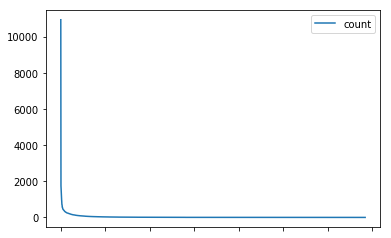

In [145]:
pd.DataFrame(pd.Series(word_counts, name='count')).sort_values('count', ascending=False).plot()

In [146]:
num_words = 3000

In [147]:
pd.DataFrame(pd.Series(word_counts, name='count')).sort_values('count', ascending=False)[:num_words].head()

,count
<num>,10934
said,5658
pct,2327
trad,1879
bil,1749


In [148]:
pd.DataFrame(pd.Series(word_counts, name='count')).sort_values('count', ascending=False)[:num_words].tail()

,count
cem,4
mdbl,4
gloom,4
bargain,4
alongsid,4


In [149]:
top_words = list(word_counts.items())
top_words.sort(key = lambda it: it[1])
top_words.reverse()
top_words = [ word for word, count in top_words[:num_words] ]
print(len(top_words))
top_words

3000


['<num>',
 'said',
 'pct',
 'trad',
 'bil',
 'year',
 'reut',
 'u',
 'bank',
 'mln',
 'produc',
 'pric',
 'would',
 'dlrs',
 'market',
 'oil',
 'off',
 'rat',
 'min',
 'export',
 'last',
 'stat',
 'econom',
 'ton',
 'new',
 'week',
 'cur',
 'govern',
 'febru',
 'jap',
 'janu',
 'country',
 'ris',
 'on',
 'import',
 'increas',
 'meet',
 'nat',
 'foreign',
 'two',
 'also',
 'end',
 'agr',
 'op',
 'fin',
 'grow',
 'company',
 'sug',
 'coff',
 'report',
 'reserv',
 'stock',
 'expect',
 'march',
 'industry',
 'cut',
 'told',
 'today',
 'world',
 'could',
 'ad',
 'ear',
 'doll',
 'day',
 'ros',
 'high',
 'exchang',
 'mon',
 'low',
 'intern',
 'money',
 'commit',
 'lt',
 'say',
 'plan',
 'bas',
 'fed',
 'opec',
 'stg',
 'cent',
 'japanes',
 'tak',
 'gold',
 'fal',
 'may',
 'consum',
 'unit',
 'ec',
 'canad',
 'brazil',
 'ship',
 'decemb',
 'barrel',
 'interest',
 'sourc',
 'talk',
 'three',
 'policy',
 'crud',
 'level',
 'work',
 'act',
 'maj',
 'first',
 'fel',
 'presid',
 'spokesm',
 'set',

In [150]:
def replace_rare_words_with_literal(string, top_words):
    return ' '.join([ (word if word in top_words else '<unk>') for word in re.split(' ', string) ])

In [151]:
prepared_documents_train = [ 
    replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_documents_train
]

prepared_documents_test = [ 
    replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_documents_test
]

In [152]:
print(prepared_documents_train[:3])
print()
print(prepared_documents_test[:3])

['bah coco review show continu throughout week bah coco zon allevy drought sint ear janu improv prospect com temporao although norm <unk> level rest comissar smi said week review dry period mean temporao lat year ar week end febru <num> <unk> <num> <unk> bag <num> <unk> kilo mak cum tot season <num> <unk> mln <num> <unk> stag last year seem coco del ear <unk> includ ar fig comissar smi said stil doubt much old crop coco stil avail harvest pract com end tot bah crop estim around <num> <unk> mln bag sal stand almost <num> <unk> mln hundr thousand bag stil hand farm <unk> export process doubt much coco would fit export ship expery <unk> obtain bah supery cert view low qual rec week farm sold good part coco held <unk> comissar smi said spot bean pric ros <num> <unk> <num> <unk> cruzado per <unk> <num> <unk> kilo bean ship reluct off nearby ship limit sal book march ship <num> <unk> <num> <unk> dlrs per ton port nam new crop sal also light op port jun july going <num> <unk> <num> <unk> dlrs

## Vectorize prepared documents

In [153]:
topics_train = data_train[['doc.topic']].values
print(topics_train[:10])

topics_test = data_test[['doc.topic']].values
print(topics_test[:10])

print(len(topics_train), len(prepared_documents_train))
print(len(topics_test), len(prepared_documents_test))
print(selected_topics)

[['cocoa']
 ['copper']
 ['coffee']
 ['sugar']
 ['trade']
 ['reserves']
 ['ship']
 ['money.supply']
 ['ship']
 ['coffee']]
[['trade']
 ['grain']
 ['ship']
 ['gold']
 ['jobs']
 ['trade']
 ['sugar']
 ['sugar']
 ['trade']
 ['trade']]
1514 1514
523 523
['crude' 'trade' 'money.fx' 'interest' 'ship' 'sugar' 'coffee' 'gold'
 'money.supply' 'gnp' 'cpi' 'copper' 'cocoa' 'jobs' 'grain' 'iron.steel'
 'alum' 'reserves']


In [154]:
# y = label_binarize(topics, classes=selected_topics)
# y = topics

y_train = label_binarize(topics_train, classes=selected_topics)
y_test = label_binarize(topics_test, classes=selected_topics)

n_classes = y_train.shape[1]

In [155]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 1))

In [156]:
tfidf_vectorizer.fit(prepared_documents_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [157]:
X_train = tfidf_vectorizer.transform(prepared_documents_train, copy=True)
X_test = tfidf_vectorizer.transform(prepared_documents_test, copy=True)

In [158]:
words_by_ids = {i:word for word,i in tfidf_vectorizer.vocabulary_.items()}

## Train classifier

In [159]:
estimator = LogisticRegression(penalty = 'l2', C = 1) # MultinomialNB(alpha=0.1)
classifier = OneVsRestClassifier(estimator)

classifier = classifier.fit(X_train, y_train)

## Evaluate results

In [160]:
y_test_predicted_labels = classifier.predict(X_test)
y_test_predicted_scores = classifier.decision_function(X_test)

In [161]:
print(len(y_test_predicted_scores))
print(y_test_predicted_scores[0])

523
[-3.66364803  3.25117246 -3.58028827 -4.07327081 -3.89251681 -4.1311311
 -3.98369201 -4.22741601 -4.39477177 -3.85481304 -5.02664254 -4.66859751
 -4.53244687 -4.65959869 -4.38047193 -4.00494245 -4.57829812 -4.63357881]


In [162]:
def print_evaluation_scores(y_test, predicted):
    print('accuracy', accuracy_score(y_test, predicted))
    for avg in [ 'micro', 'macro', 'weighted' ]:
        print('f1', avg, f1_score(y_test, predicted, average = avg))
        print('precision', avg, average_precision_score(y_test, predicted, average = avg))

In [163]:
print_evaluation_scores(y_test, y_test_predicted_labels)

accuracy 0.4321223709369025
f1 micro 0.6010638297872339
precision micro 0.4580101363480758
f1 macro 0.3703001693660322
precision macro 0.3041210205935042
f1 weighted 0.5464257478921518
precision weighted 0.4720480358787636


/home/flint/dev/rtc/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [166]:
y_test

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [167]:
y_test_predicted_scores

array([[-3.66364803,  3.25117246, -3.58028827, ..., -4.00494245,
        -4.57829812, -4.63357881],
       [-2.66245242, -2.93475487, -3.32734362, ..., -3.88263024,
        -4.12135728, -4.41755968],
       [-2.99020461, -2.61068075, -3.09825922, ..., -4.18757335,
        -4.05167786, -4.4085064 ],
       ...,
       [ 0.29677277, -2.42092681, -3.21520344, ..., -3.99947043,
        -3.85236258, -4.6897488 ],
       [-2.50396685, -2.49754843, -3.19849087, ..., -4.00085356,
        -4.19393129, -4.62370429],
       [-2.05847037, -2.73901354, -3.01987845, ..., -3.77391031,
        -3.80906354, -3.99328254]])

In [169]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_test_predicted_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_test_predicted_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [170]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

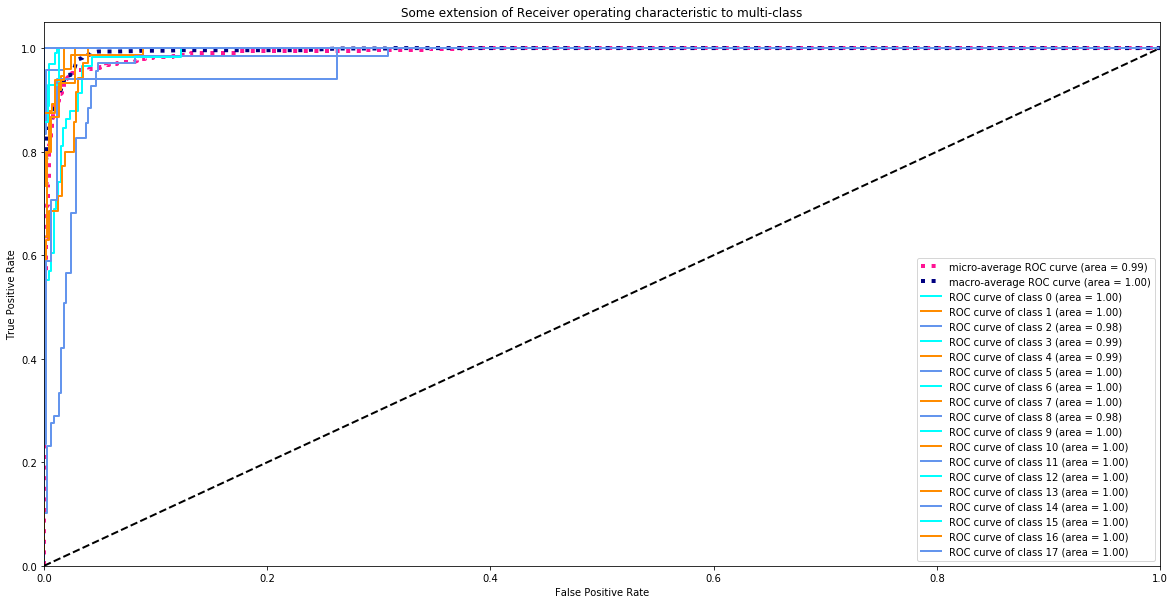

In [171]:
lw = 2

# Plot all ROC curves
plt.figure(figsize=(20, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()